In [1]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms

In [2]:
class Attack(object):
    def __init__(self, net, criterion):
        self.net = net
        self.criterion = criterion

    def fgsm(self, x, y, targeted=False, eps=0.03, x_val_min=-1, x_val_max=1):
        x_adv = x.requires_grad_(True)
        h_adv = self.net(x_adv)
        self.net.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.fill_(0)
        if targeted:
            cost = self.criterion(h_adv, y)
        else:
            cost = -self.criterion(h_adv, y)

        cost.backward()

        x_adv.grad.sign_()
        x_adv = x_adv - eps*x_adv.grad
        x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


        h = self.net(x)
        h_adv = self.net(x_adv)

        return x_adv, h_adv, h

    def i_fgsm(self, x, y, targeted=False, eps=0.03, alpha=1, iteration=1, x_val_min=-1, x_val_max=1):
        x_adv = Variable(x.data, requires_grad=True)
        for i in range(iteration):
            h_adv = self.net(x_adv)
            if targeted:
                cost = self.criterion(h_adv, y)
            else:
                cost = -self.criterion(h_adv, y)

            self.net.zero_grad()
            if x_adv.grad is not None:
                x_adv.grad.data.fill_(0)
            cost.backward()

            x_adv.grad.sign_()
            x_adv = x_adv - alpha*x_adv.grad
            x_adv = torch.clamp(x_adv, x-eps, x+eps)
            x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
            x_adv = Variable(x_adv.data, requires_grad=True)

        h = self.net(x)
        h_adv = self.net(x_adv)

        return x_adv, h_adv, h

In [3]:
def imshow(img):
    npimg = img.numpy()
    npimg = npimg / 2 + 0.5     # unnormalize
    plt.figure(figsize=(2,2))
    plt.imshow(npimg.reshape(npimg.shape[1: 3]), cmap='gray')
    plt.show()

# Black-box Attack
Generate adversarial images from model1 (small size), then use the adversarial examples to attack model2 (median size).

In [4]:
dataroot = 'D:/Lab/dataset'
model_file1 = './models/model1.md'
k_fs = 10
dim = 28*28
suffix = '_reg_k10'
model_file2 = './models/model_info' + suffix + '.md'

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) 

model1 = torch.load(model_file1).cpu()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28*k_fs, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.dropout(x, training=self.training, p=0.8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.8)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)    

model2 = torch.load(model_file2).cpu()

print(model1)
print(model2)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Net(
  (fc1): Linear(in_features=7840, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Prepare to compute features.

In [5]:
train_max_min_file = './models/train_max_min' + suffix + '.npz'

with open(train_max_min_file, 'rb') as fp:
    npzfile = np.load(fp)
    train_max, train_min = npzfile['train_max'], npzfile['train_min']
    
feature_path = './models/feats' + suffix

with open(feature_path, 'rb') as fp:
    fs = pickle.load(fp)
print(len(fs))

# maps a pixel to quantized index
def q_map(x, threshold=0.4):
    if x < threshold:
        return 0
    else:
        return 1

10


In [6]:
# InfoTrans + NormalTrans
class InfoFeat(object):
    def __init__(self, _max, _min, q_map=q_map, fs=fs, q_dim=2):
        self._max = _max
        self._min = _min
        self.q_map = q_map
        self.fs = fs
        self.k_fs = len(fs)
        self.q_dim = q_dim
    
    def __call__(self, img):
        feats = np.zeros((img.shape[0], img.shape[1]*self.k_fs))
        for i in range(img.shape[0]):
            for idx, pixel in enumerate(img[i]):
                for k in range(self.k_fs):
                    feats[i, k*dim+idx] = self.fs[k][idx*self.q_dim+self.q_map(pixel)]
        res = feats
        for k in range(k_fs):
            res[:, k*dim:(k+1)*dim] = (res[:, k*dim:(k+1)*dim] - self._min[k]) / (self._max[k] - self._min[k]) * 2 - 1      
        return torch.from_numpy(res).float()

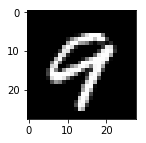

tensor([9])


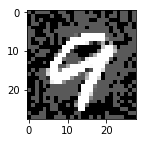

Normal Pred: tensor([9]), Adv. Pred: tensor([9])


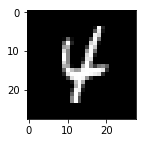

tensor([4])


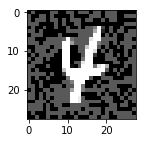

Normal Pred: tensor([4]), Adv. Pred: tensor([4])


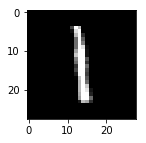

tensor([1])


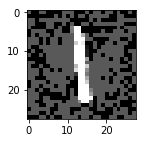

Normal Pred: tensor([1]), Adv. Pred: tensor([1])


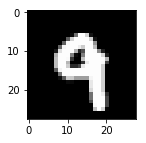

tensor([9])


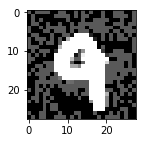

Normal Pred: tensor([9]), Adv. Pred: tensor([9])


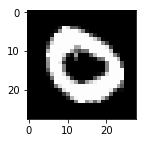

tensor([0])


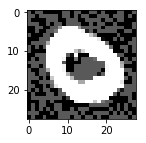

Normal Pred: tensor([0]), Adv. Pred: tensor([0])


In [7]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=True)

# get some random training images
dataiter = iter(test_loader)
for _ in range(5):
    image, label = dataiter.next()

    # print(image.shape)
    imshow(image[0])
    print(label)

    att = Attack(model1, F.nll_loss)
    x_adv, h_adv, h = att.fgsm(image, label, eps=0.3)

    imshow(x_adv[0].detach())
    
    norm_feat = InfoFeat(train_max, train_min)(image.view(image.shape[0], -1))
    adv_feat = InfoFeat(train_max, train_min)(x_adv.view(x_adv.shape[0], -1))
    
    norm_pred = model2(norm_feat).max(1)[1]
    adv_pred = model2(adv_feat).max(1)[1]

    print('Normal Pred: {}, Adv. Pred: {}'.format(norm_pred, adv_pred))

In [8]:
def test(model, test_loader, att_fn, eps=0.3):
    model.eval()
    correct = 0
    pred_correct = 0 # normal pred same as ground truth
    for idx, (image, target) in enumerate(test_loader):
        x_adv, h_adv, h = att_fn(image, target, eps=eps)
        
        norm_feat = InfoFeat(train_max, train_min)(image.view(image.shape[0], -1))
        adv_feat = InfoFeat(train_max, train_min)(x_adv.view(x_adv.shape[0], -1))

        norm_pred = model(norm_feat).max(1)[1].cpu()
        adv_pred = model(adv_feat).max(1)[1].cpu()        
        pred_truth = norm_pred.eq(target.cpu())
        pred_correct += pred_truth.sum().item()
        correct += (pred_truth * norm_pred.eq(adv_pred)).sum().item()
        if (idx+1) % 1 == 0:
            if pred_correct > 0:
                tmp = 100. * (pred_correct - correct) / pred_correct
            else:
                tmp = 0
            print('Step: {} Attack Succ.: {}/{} ({:.6f}%)'.format(
                (idx+1), pred_correct - correct, pred_correct, tmp))

    print('Final Results\nPred Correct: {}, Correct: {}, Total: {}, \nTest Accuracy: {}/{} ({:.6f}%), \nAttack Succ: {}/{} ({:.6f}%)\n'.format(
        pred_correct, correct, len(test_loader.dataset),
        pred_correct, len(test_loader.dataset),
        100. * pred_correct / len(test_loader.dataset),
        pred_correct-correct, pred_correct,
        100. * (pred_correct-correct) / pred_correct))

In [9]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=100, shuffle=True)

In [10]:
test(model2, test_loader, att.fgsm, eps=0.05)

Step: 1 Attack Succ.: 1/85 (1.176471%)
Step: 2 Attack Succ.: 1/165 (0.606061%)
Step: 3 Attack Succ.: 3/244 (1.229508%)
Step: 4 Attack Succ.: 4/330 (1.212121%)
Step: 5 Attack Succ.: 5/413 (1.210654%)
Step: 6 Attack Succ.: 6/495 (1.212121%)
Step: 7 Attack Succ.: 6/574 (1.045296%)
Step: 8 Attack Succ.: 9/654 (1.376147%)
Step: 9 Attack Succ.: 9/740 (1.216216%)
Step: 10 Attack Succ.: 9/821 (1.096224%)
Step: 11 Attack Succ.: 10/910 (1.098901%)
Step: 12 Attack Succ.: 13/997 (1.303912%)
Step: 13 Attack Succ.: 13/1080 (1.203704%)
Step: 14 Attack Succ.: 13/1165 (1.115880%)
Step: 15 Attack Succ.: 14/1249 (1.120897%)
Step: 16 Attack Succ.: 14/1339 (1.045556%)
Step: 17 Attack Succ.: 14/1424 (0.983146%)
Step: 18 Attack Succ.: 14/1510 (0.927152%)
Step: 19 Attack Succ.: 14/1596 (0.877193%)
Step: 20 Attack Succ.: 15/1681 (0.892326%)
Step: 21 Attack Succ.: 15/1762 (0.851305%)
Step: 22 Attack Succ.: 17/1846 (0.920910%)
Step: 23 Attack Succ.: 18/1932 (0.931677%)
Step: 24 Attack Succ.: 19/2013 (0.943865%)


In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model2, test_loader, att.fgsm, eps=0.1)

Step: 1 Attack Succ.: 9/420 (2.142857%)
Step: 2 Attack Succ.: 16/857 (1.866978%)
Step: 3 Attack Succ.: 24/1288 (1.863354%)
Step: 4 Attack Succ.: 29/1737 (1.669545%)
Step: 5 Attack Succ.: 38/2179 (1.743919%)
Step: 6 Attack Succ.: 50/2622 (1.906941%)
Step: 7 Attack Succ.: 56/3053 (1.834261%)
Step: 8 Attack Succ.: 66/3473 (1.900374%)
Step: 9 Attack Succ.: 70/3915 (1.787995%)
Step: 10 Attack Succ.: 79/4356 (1.813590%)
Step: 11 Attack Succ.: 83/4794 (1.731331%)
Step: 12 Attack Succ.: 87/5227 (1.664435%)
Step: 13 Attack Succ.: 97/5656 (1.714993%)
Step: 14 Attack Succ.: 107/6103 (1.753236%)
Step: 15 Attack Succ.: 111/6547 (1.695433%)
Step: 16 Attack Succ.: 117/6973 (1.677900%)
Step: 17 Attack Succ.: 125/7397 (1.689874%)
Step: 18 Attack Succ.: 131/7827 (1.673694%)
Step: 19 Attack Succ.: 143/8256 (1.732074%)
Step: 20 Attack Succ.: 147/8500 (1.729412%)
Final Results
Pred Correct: 8500, Correct: 8353, Total: 10000, 
Test Accuracy: 8500/10000 (85.000000%), 
Attack Succ: 147/8500 (1.729412%)



In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model2, test_loader, att.fgsm, eps=0.2)

Step: 1 Attack Succ.: 14/420 (3.333333%)
Step: 2 Attack Succ.: 30/861 (3.484321%)
Step: 3 Attack Succ.: 46/1286 (3.576983%)
Step: 4 Attack Succ.: 60/1726 (3.476246%)
Step: 5 Attack Succ.: 75/2163 (3.467406%)
Step: 6 Attack Succ.: 93/2594 (3.585197%)
Step: 7 Attack Succ.: 104/3029 (3.433476%)
Step: 8 Attack Succ.: 121/3466 (3.491056%)
Step: 9 Attack Succ.: 134/3914 (3.423608%)
Step: 10 Attack Succ.: 149/4359 (3.418215%)
Step: 11 Attack Succ.: 160/4796 (3.336113%)
Step: 12 Attack Succ.: 175/5246 (3.335875%)
Step: 13 Attack Succ.: 191/5656 (3.376945%)
Step: 14 Attack Succ.: 201/6091 (3.299951%)
Step: 15 Attack Succ.: 223/6517 (3.421820%)
Step: 16 Attack Succ.: 234/6961 (3.361586%)
Step: 17 Attack Succ.: 251/7399 (3.392350%)
Step: 18 Attack Succ.: 266/7842 (3.391992%)
Step: 19 Attack Succ.: 286/8266 (3.459956%)
Step: 20 Attack Succ.: 295/8500 (3.470588%)
Final Results
Pred Correct: 8500, Correct: 8205, Total: 10000, 
Test Accuracy: 8500/10000 (85.000000%), 
Attack Succ: 295/8500 (3.470588%

In [13]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model2, test_loader, att.fgsm, eps=0.3)

Step: 1 Attack Succ.: 24/441 (5.442177%)
Step: 2 Attack Succ.: 45/881 (5.107832%)
Step: 3 Attack Succ.: 72/1327 (5.425772%)
Step: 4 Attack Succ.: 97/1757 (5.520774%)
Step: 5 Attack Succ.: 121/2197 (5.507510%)
Step: 6 Attack Succ.: 147/2625 (5.600000%)
Step: 7 Attack Succ.: 163/3059 (5.328539%)
Step: 8 Attack Succ.: 190/3505 (5.420827%)
Step: 9 Attack Succ.: 202/3934 (5.134723%)
Step: 10 Attack Succ.: 224/4360 (5.137615%)
Step: 11 Attack Succ.: 248/4803 (5.163440%)
Step: 12 Attack Succ.: 271/5246 (5.165841%)
Step: 13 Attack Succ.: 289/5682 (5.086237%)
Step: 14 Attack Succ.: 308/6109 (5.041742%)
Step: 15 Attack Succ.: 329/6545 (5.026738%)
Step: 16 Attack Succ.: 353/6971 (5.063836%)
Step: 17 Attack Succ.: 385/7408 (5.197084%)
Step: 18 Attack Succ.: 413/7839 (5.268529%)
Step: 19 Attack Succ.: 439/8272 (5.307060%)
Step: 20 Attack Succ.: 458/8500 (5.388235%)
Final Results
Pred Correct: 8500, Correct: 8042, Total: 10000, 
Test Accuracy: 8500/10000 (85.000000%), 
Attack Succ: 458/8500 (5.38823

In [14]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model2, test_loader, att.fgsm, eps=0.4)

Step: 1 Attack Succ.: 30/424 (7.075472%)
Step: 2 Attack Succ.: 57/856 (6.658879%)
Step: 3 Attack Succ.: 83/1290 (6.434109%)
Step: 4 Attack Succ.: 117/1742 (6.716418%)
Step: 5 Attack Succ.: 155/2173 (7.132996%)
Step: 6 Attack Succ.: 190/2615 (7.265774%)
Step: 7 Attack Succ.: 226/3047 (7.417132%)
Step: 8 Attack Succ.: 257/3481 (7.382936%)
Step: 9 Attack Succ.: 291/3909 (7.444359%)
Step: 10 Attack Succ.: 312/4354 (7.165825%)
Step: 11 Attack Succ.: 350/4784 (7.316054%)
Step: 12 Attack Succ.: 385/5228 (7.364193%)
Step: 13 Attack Succ.: 427/5662 (7.541505%)
Step: 14 Attack Succ.: 459/6097 (7.528293%)
Step: 15 Attack Succ.: 488/6540 (7.461774%)
Step: 16 Attack Succ.: 518/6973 (7.428653%)
Step: 17 Attack Succ.: 559/7413 (7.540807%)
Step: 18 Attack Succ.: 593/7838 (7.565706%)
Step: 19 Attack Succ.: 621/8268 (7.510885%)
Step: 20 Attack Succ.: 640/8500 (7.529412%)
Final Results
Pred Correct: 8500, Correct: 7860, Total: 10000, 
Test Accuracy: 8500/10000 (85.000000%), 
Attack Succ: 640/8500 (7.5294